<H1>Необходимо предсказать верхнюю границу заработной платы (salary_to) для вакансии</H1>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from datetime import datetime, timedelta, date
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import xlrd
from itertools import chain
pd.set_option('display.max_colwidth', None)

Считываем данные для обучения:

In [2]:
pd.options.display.max_rows = 2

df = pd.read_csv('X_train.csv', parse_dates=['published_at', 'created_at'])

df
#df.describe()

,id,name,has_test,response_letter_required,salary_from,salary_currency,salary_gross,published_at,created_at,employer_name,description,area_id,area_name
0,29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,NaN,RUR,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,Villagio Estate,"<strong>Обязанности:</strong> <p>​​​​​- Прием и обработка первичных обращений;</p> <p>- Оценка и заключение договоров с объектами (без поиска);</p> <p>- Работа с базой клиентов;</p> <p>- Отслеживание тенденций рынка;</p> <p><strong>Требования:</strong></p> <p>- Опыт работы на аналогичной позиции не менее 1 года;</p> <p>- Понимание основных юридических аспектов оформления сделок;</p> <p>- Знание технологии продаж;</p> <p>- Высокий уровень коммуникативных навыков;</p> <p>- Желание работать и развиваться в команде профессионалов;</p> <p>- Оперативное взаимодействие с клиентом, личная активность;</p> <p>- Грамотная речь;</p> <p>- Знание рынка недвижимости сегмента deluxe и elite</p> <p><strong>Условия:</strong></p> <p><strong>- Основное место работы: метро Проспект Мира/Достоевская</strong></p> <p><strong>- з/п комиссионая</strong></p> <p> </p>",1,Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27933,15795,Гейм-дизайнер,False,False,30000.0,RUR,False,2021-08-11 09:41:00+00:00,2021-08-11 09:41:00+00:00,Рэдвуд,"<p>Нам хотелось бы видеть в своей команде неравнодушного к своему труду и его результатам кандидата. Готовый создавать вместе с нами не штампованное однотипное унылое Г., а продукты, способные претендовать на звание лучших игр в своем классе.</p> <p><strong>Что ищем в кандидате:</strong></p> <ul> <li>Склонность/любовь к играм стратегического характера (!);</li> <li>Трудоспособность не ниже уровня &quot;Бог&quot;;</li> <li>Знание орфографии, способность четко выражать свою мысль, структурировать информацию;</li> <li>Аналитический склад ума</li> </ul> <p><strong>Будет плюсом:</strong></p> <ul> <li>Уверенное знание английского языка;</li> <li>Дизайнерские навыки;</li> <li>Навыки программирования/тестирования игр;</li> </ul> <p><strong>Что нужно будет делать:</strong></p> <ul> <li>Прототипировать/Концептировать/Писать диздоки по вижену старшего Г.Д;</li> <li>Предлагать свои решения/механики по поводу и без;</li> <li>Тестировать и сопровождать внедряемый функционал в игру;</li> <li>Видеть и анализировать обратную связь от пользователей;</li> <li>Кайфовать от процесса разработки игр;</li> </ul> <p><strong>Условия:</strong></p> <ul> <li>Удаленный вариант взаимодействия (дискорд+трелло)</li> <li>Стабильный доход &quot;в белую&quot;</li> <li>Премиальные за успешно завершенный проект</li> <li>Рост в зарплате и карьерная перспектива: Младший Г.Д. &gt;&gt; Старший Г.Д.&gt;&gt; &quot;О Великий Бог Ра&quot;.</li> <li>Возможность стать партнером через 2 года работы (доля акций студии)</li> </ul> <p><strong>О нас:</strong></p> <ul> <li>Небольшая дружная команда. Уже не стартап. Но еще не мавры. Есть успешно запущенный проект в Steam с хорошим рейтингом и фанбазой. 2 проекта на уровне концепта, готовятся к прототипированию в обозримом будущем.</li> </ul> <p>P.S. Пожалуйста, при отклике на вакансию, сопроводите его сообщением &quot;Привет из Калифорнии!&quot; И вкратце опишите свой игровой опыт, любимые игры, чем вы сможете быт нам полезны, и почему должны взять именно Вас в нашу дружную индейскую каноэ? Так мы поймем, что вы не откликаетесь &quot;на автомате&quot;, а внимательно прочитали вакансию. В ответ вышлем тестовое задание для проверки Ваших способностей.</p>",11,Барнаул


Считываем значения salary_to для данных для обучения и мерджим с предыдущей таблицей

In [3]:
df1 = pd.read_csv('y_train.csv')
df = df.set_index('id').join(df1.set_index('id'))
df

,name,has_test,response_letter_required,salary_from,salary_currency,salary_gross,published_at,created_at,employer_name,description,area_id,area_name,salary_to
id,,,,,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,NaN,RUR,False,2020-06-16 06:45:04+00:00,2020-06-16 06:45:04+00:00,Villagio Estate,"<strong>Обязанности:</strong> <p>​​​​​- Прием и обработка первичных обращений;</p> <p>- Оценка и заключение договоров с объектами (без поиска);</p> <p>- Работа с базой клиентов;</p> <p>- Отслеживание тенденций рынка;</p> <p><strong>Требования:</strong></p> <p>- Опыт работы на аналогичной позиции не менее 1 года;</p> <p>- Понимание основных юридических аспектов оформления сделок;</p> <p>- Знание технологии продаж;</p> <p>- Высокий уровень коммуникативных навыков;</p> <p>- Желание работать и развиваться в команде профессионалов;</p> <p>- Оперативное взаимодействие с клиентом, личная активность;</p> <p>- Грамотная речь;</p> <p>- Знание рынка недвижимости сегмента deluxe и elite</p> <p><strong>Условия:</strong></p> <p><strong>- Основное место работы: метро Проспект Мира/Достоевская</strong></p> <p><strong>- з/п комиссионая</strong></p> <p> </p>",1,Москва,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15795,Гейм-дизайнер,False,False,30000.0,RUR,False,2021-08-11 09:41:00+00:00,2021-08-11 09:41:00+00:00,Рэдвуд,"<p>Нам хотелось бы видеть в своей команде неравнодушного к своему труду и его результатам кандидата. Готовый создавать вместе с нами не штампованное однотипное унылое Г., а продукты, способные претендовать на звание лучших игр в своем классе.</p> <p><strong>Что ищем в кандидате:</strong></p> <ul> <li>Склонность/любовь к играм стратегического характера (!);</li> <li>Трудоспособность не ниже уровня &quot;Бог&quot;;</li> <li>Знание орфографии, способность четко выражать свою мысль, структурировать информацию;</li> <li>Аналитический склад ума</li> </ul> <p><strong>Будет плюсом:</strong></p> <ul> <li>Уверенное знание английского языка;</li> <li>Дизайнерские навыки;</li> <li>Навыки программирования/тестирования игр;</li> </ul> <p><strong>Что нужно будет делать:</strong></p> <ul> <li>Прототипировать/Концептировать/Писать диздоки по вижену старшего Г.Д;</li> <li>Предлагать свои решения/механики по поводу и без;</li> <li>Тестировать и сопровождать внедряемый функционал в игру;</li> <li>Видеть и анализировать обратную связь от пользователей;</li> <li>Кайфовать от процесса разработки игр;</li> </ul> <p><strong>Условия:</strong></p> <ul> <li>Удаленный вариант взаимодействия (дискорд+трелло)</li> <li>Стабильный доход &quot;в белую&quot;</li> <li>Премиальные за успешно завершенный проект</li> <li>Рост в зарплате и карьерная перспектива: Младший Г.Д. &gt;&gt; Старший Г.Д.&gt;&gt; &quot;О Великий Бог Ра&quot;.</li> <li>Возможность стать партнером через 2 года работы (доля акций студии)</li> </ul> <p><strong>О нас:</strong></p> <ul> <li>Небольшая дружная команда. Уже не стартап. Но еще не мавры. Есть успешно запущенный проект в Steam с хорошим рейтингом и фанбазой. 2 проекта на уровне концепта, готовятся к прототипированию в обозримом будущем.</li> </ul> <p>P.S. Пожалуйста, при отклике на вакансию, сопроводите его сообщением &quot;Привет из Калифорнии!&quot; И вкратце опишите свой игровой опыт, любимые игры, чем вы сможете быт нам полезны, и почему должны взять именно Вас в нашу дружную индейскую каноэ? Так мы поймем, что вы не откликаетесь &quot;на автомате&quot;, а внимательно прочитали вакансию. В ответ вышлем тестовое задание для проверки Ваших способностей.</p>",11,Барнаул,60000.0


<H1>Исследование данных / Data exploration</H1>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   name                      27934 non-null  object             
 1   has_test                  27934 non-null  bool               
 2   response_letter_required  27934 non-null  bool               
 3   salary_from               23902 non-null  float64            
 4   salary_currency           27934 non-null  object             
 5   salary_gross              27786 non-null  object             
 6   published_at              27934 non-null  datetime64[ns, UTC]
 7   created_at                27934 non-null  datetime64[ns, UTC]
 8   employer_name             27934 non-null  object             
 9   description               27933 non-null  object             
 10  area_id                   27934 non-null  int64              
 11  area_name       

Три колонки имеют пустоты: salary_from, salary_gross, и у 1-го нет description

In [5]:
pd.options.display.max_rows = 13
df.describe(include='O')

,name,salary_currency,salary_gross,employer_name,description,area_name
count,27934,27934,27786,27934,27933,27934
unique,16395,1,2,13318,23681,156
top,Менеджер по продажам,RUR,False,Пятёрочка,"<p><strong>Обязанности:</strong></p><ul><li>Обслуживание покупателей на кассе (наличный и безналичный расчет)</li><li>Выкладка товара в зале</li><li>Отслеживание сроков годности товара</li><li>Проверка наличия ценников</li><li>Консультация покупателей в зале</li></ul><p><strong>Требования:</strong></p><ul><li>Ответственность, дисциплинированность, внимательность</li></ul><p><strong>Условия:</strong></p><ul><li>График работы 5/2, 2/2, возможен неполный рабочий день, неполная рабочая неделя</li><li>Возможность подработки (работа по совместительству)</li><li>Социальные гарантии, оплата отпусков и больничных листов</li><li>Работа рядом с домом</li><li>Скидки в магазинах сети</li><li>Фирменная спецодежда</li><li>Возможность профессионального и карьерного роста, корпоративное обучение</li><li>Корпоративные мероприятия и конкурсы</li></ul>",Москва
freq,337,27934,18726,927,624,20512


<H1>Категориальные / Category</H1>

Во первых, колонка description выглядит сложной и ненужной, отбросим её

In [6]:
df = df.drop(columns=['description'])

Далее, salary_currency имеет unique=1, значит эту колонку можно удалить

In [7]:
df = df.drop(columns=['salary_currency'])

Столбцы published_at и created_at выглядят одинаковыми, проверим

In [8]:
(df['published_at']==df['created_at']).value_counts()

True    27934
Name: count, dtype: int64

Таким образом, столбцы published_at и created_at напрямую коррелируют, значит один из них можно отбросить

In [9]:
df = df.drop(columns=['created_at'])

In [10]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name
count,27934,27786,27934,27934
unique,16395,2,13318,156
top,Менеджер по продажам,False,Пятёрочка,Москва
freq,337,18726,927,20512


Оставшиеся 3 столбца: name, employer_name и area_name имеют достаточно много уникальных значений.

Начнем с area_name

In [11]:
pd.options.display.max_rows = 20
df['area_name'].value_counts()

area_name
Москва                         20512
Санкт-Петербург                 5393
Новосибирск                      201
Краснодар                        178
Екатеринбург                     158
                               ...  
Каменск-Шахтинский                 1
Стерлитамак                        1
Турция                             1
Донецк (Ростовская область)        1
Курган                             1
Name: count, Length: 156, dtype: int64

Во первых, в таблице есть area_id, который напрямую коррелирует с area_name. Удалим его

In [12]:
df = df.drop(columns=['area_id'])

Далее, выделим три типа area: Москва, СП и другие.

In [13]:
df.loc[df["area_name"].value_counts()[df["area_name"]].values < 1000, "area_name"] = "Other"
df['area_name'].value_counts()

area_name
Москва             20512
Санкт-Петербург     5393
Other               2029
Name: count, dtype: int64

In [14]:
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,area_name,salary_to
id,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,NaN,False,2020-06-16 06:45:04+00:00,Villagio Estate,Москва,200000.0
26052,Product marketing manager / Продуктовый маркетолог,False,False,120000.0,False,2020-07-22 10:24:15+00:00,CityAds Media,Москва,170000.0
24055,Программист Python (Middle),False,False,NaN,False,2020-04-12 08:19:08+00:00,Лендсбэй,Москва,120000.0
4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.0,True,2020-08-24 01:16:52+00:00,Пятёрочка,Москва,38000.0
16856,Дизайнер-визуализатор,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Моллдекор Рус,Москва,35000.0
...,...,...,...,...,...,...,...,...,...
16850,Директор департамента по административной и кадровой работе,False,False,120000.0,False,2021-10-03 10:04:45+00:00,Балтик Граунд Сервисес РУ,Москва,150000.0
6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.0,True,2020-09-07 00:32:00+00:00,Пятёрочка,Москва,38000.0
11284,Младший аналитик данных,False,False,50000.0,False,2021-04-20 08:25:44+00:00,Баскаков Дмитрий Владимирович,Москва,70000.0


Далее посмотрим на employer_name

In [15]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    927
Пятерочка                    669
Перекресток                  324
Билайн                       261
JCat.ru                       70
                            ... 
Торговая группа ПТК            1
LTG Consulting                 1
ExMail                         1
Албаков Руслан Борисович       1
Балтик Граунд Сервисес РУ      1
Name: count, Length: 13318, dtype: int64

Во первых, можно увидеть два разных написания "Пятерочка", оставим одно:

In [16]:
df = df.replace(to_replace ="Пятерочка", value ="Пятёрочка") 

df.employer_name.unique()

array(['Villagio Estate', 'CityAds Media', 'Лендсбэй', ...,
       'Харчевников Александр Андреевич', 'RedStone Capital',
       'Балтик Граунд Сервисес РУ'], dtype=object)

In [17]:
df['employer_name'].value_counts()

employer_name
Пятёрочка                    1596
Перекресток                   324
Билайн                        261
JCat.ru                        70
Skyeng                         63
                             ... 
Торговая группа ПТК             1
LTG Consulting                  1
ExMail                          1
Албаков Руслан Борисович        1
Балтик Граунд Сервисес РУ       1
Name: count, Length: 13317, dtype: int64

Здесь мы сделаем также, как и с area_name:

In [18]:
df.loc[df["employer_name"].value_counts()[df["employer_name"]].values < 100, "employer_name"] = "Other"
df['employer_name'].value_counts()

employer_name
Other          25753
Пятёрочка       1596
Перекресток      324
Билайн           261
Name: count, dtype: int64

Теперь рассмотрим последний столбец: name

In [19]:
df['name'].value_counts()

name
Менеджер по продажам                                   337
Менеджер по работе с клиентами                         201
Юрист                                                  162
Помощник юриста                                        149
Аналитик                                               145
                                                      ... 
Бизнес-аналитик(Внедренец/ Ведущий бизнес-аналитик)      1
Руководитель департамента коммерческой недвижимости      1
Логист- оператор / Грузчик (ТРК Европолис)               1
User Acquisition Manager                                 1
Копирайтер / контент менеджер                            1
Name: count, Length: 16395, dtype: int64

Можно увидеть перечисления через /, либо доп. указания в скобках. Уберем их:

In [20]:
df = pd.concat([df, df.name.str.split('(', expand=True)[0]\
                .rename('name_new')], axis=1)
df = pd.concat([df, df.name_new.str.split('/', expand=True)[0]\
                .rename('name_new1')], axis=1)
df

,name,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,area_name,salary_to,name_new,name_new1
id,,,,,,,,,,,
29083,Менеджер по продажам (брокер) элитной городской недвижимости,False,False,NaN,False,2020-06-16 06:45:04+00:00,Other,Москва,200000.0,Менеджер по продажам,Менеджер по продажам
26052,Product marketing manager / Продуктовый маркетолог,False,False,120000.0,False,2020-07-22 10:24:15+00:00,Other,Москва,170000.0,Product marketing manager / Продуктовый маркетолог,Product marketing manager
24055,Программист Python (Middle),False,False,NaN,False,2020-04-12 08:19:08+00:00,Other,Москва,120000.0,Программист Python,Программист Python
4408,"Продавец-кассир (Москва, Вернадского, 93)",False,False,33500.0,True,2020-08-24 01:16:52+00:00,Пятёрочка,Москва,38000.0,Продавец-кассир,Продавец-кассир
16856,Дизайнер-визуализатор,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Other,Москва,35000.0,Дизайнер-визуализатор,Дизайнер-визуализатор
...,...,...,...,...,...,...,...,...,...,...,...
16850,Директор департамента по административной и кадровой работе,False,False,120000.0,False,2021-10-03 10:04:45+00:00,Other,Москва,150000.0,Директор департамента по административной и кадровой работе,Директор департамента по административной и кадровой работе
6265,"Продавец-кассир (г Москва, ул Смольная, д 67 к 2)",False,False,33500.0,True,2020-09-07 00:32:00+00:00,Пятёрочка,Москва,38000.0,Продавец-кассир,Продавец-кассир
11284,Младший аналитик данных,False,False,50000.0,False,2021-04-20 08:25:44+00:00,Other,Москва,70000.0,Младший аналитик данных,Младший аналитик данных


In [21]:
df['name_new1'].value_counts()

name_new1
Продавец-кассир                                                1133
Менеджер по продажам                                            355
Уборщица                                                        303
Менеджер по работе с клиентами                                  212
Менеджер по продажам                                            197
                                                               ... 
Ассистент руководителя проектов                                   1
Инженер - конструктор НКУ                                         1
Юрист в Аутсорсинговую компанию                                   1
Ведущий специалист по проектированию                              1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 10776, dtype: int64

Можно увидеть, что есть два разных "Менеджер по продажам", видимо, у одного из них есть в конце лишние символы. Уберем:

In [22]:
df['name_new1'] = df['name_new1'].str.strip()
df['name_new1'].value_counts()

name_new1
Продавец-кассир                                                1166
Менеджер по продажам                                            552
Уборщица                                                        359
Менеджер по работе с клиентами                                  282
Продавец-консультант                                            264
                                                               ... 
Трафик менеджер                                                   1
Ведущий менеджер по продаже каркасных домов                       1
Менеджер по удаленным продажам                                    1
Монтажник наружных трубопроводов НВК                              1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 9720, dtype: int64

Можно увидеть ещё менеджеров по проадажам, но конкретных (караксных домов, удаленных). Сделаем их обычными менеджерами по продажам:

In [23]:
#df.loc[(df['name_new1'].str.contains('менеджер', case=False) and df['name_new1'].str.contains('продаж', case=False)).bool(), 'name_new1'] = 'Менеджер по продажам'
df.name_new1 = df.name_new1.apply(lambda x: 'Менеджер по продажам' if (('менеджер' in x or 'Менеджер' in x) and ('продаж' in x or 'Продаж' in x)) else x)
df['name_new1'].value_counts()

name_new1
Менеджер по продажам                                           1556
Продавец-кассир                                                1166
Уборщица                                                        359
Менеджер по работе с клиентами                                  282
Продавец-консультант                                            264
                                                               ... 
Главный редактор журнала                                          1
Оператор Склада AMAZON в Польше                                   1
Трафик менеджер                                                   1
Монтажник наружных трубопроводов НВК                              1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 9189, dtype: int64

In [24]:
df.name_new1 = df.name_new1.apply(lambda x: 'Маркетолог' if ('маркетолог' in x or 'Маркетолог' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер по продажам                                           1556
Продавец-кассир                                                1166
Уборщица                                                        359
Менеджер по работе с клиентами                                  282
Маркетолог                                                      279
                                                               ... 
Контент-менеджер в интернет-магазин одежды                        1
Главный редактор журнала                                          1
Оператор Склада AMAZON в Польше                                   1
Трафик менеджер                                                   1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 9113, dtype: int64

In [25]:
df.name_new1 = df.name_new1.apply(lambda x: 'Менеджер' if ('менеджер' in x or 'Менеджер' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                                                       4336
Продавец-кассир                                                1166
Уборщица                                                        359
Маркетолог                                                      279
Продавец-консультант                                            264
                                                               ... 
Мастер газовой службы                                             1
Инженер строитель                                                 1
Автор работ по экологии                                           1
Бухгалтер на участок по учету кассовых операций                   1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 8157, dtype: int64

In [26]:
df.name_new1 = df.name_new1.apply(lambda x: 'Бухгалтер' if ('бухгалтер' in x or 'Бухгалтер' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                                                       4336
Продавец-кассир                                                1166
Бухгалтер                                                       395
Уборщица                                                        359
Маркетолог                                                      279
                                                               ... 
Ассистент руководителя проектов                                   1
Инженер - конструктор НКУ                                         1
Юрист в Аутсорсинговую компанию                                   1
Ведущий специалист по проектированию                              1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 8024, dtype: int64

In [27]:
df.name_new1 = df.name_new1.apply(lambda x: 'Юрист' if ('юрист' in x or 'Юрист' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                                                       4336
Продавец-кассир                                                1166
Юрист                                                           650
Бухгалтер                                                       395
Уборщица                                                        359
                                                               ... 
Монтажник СКС                                                     1
Психолог на горячую линию помощи наркозависимым                   1
Digital тренер онлайн                                             1
Техник-лаборант                                                   1
Директор департамента по административной и кадровой работе       1
Name: count, Length: 7916, dtype: int64

In [28]:
df.name_new1 = df.name_new1.apply(lambda x: 'Директор' if ('директор' in x or 'Директор' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                                  4336
Продавец-кассир                           1166
Юрист                                      650
Бухгалтер                                  395
Уборщица                                   359
                                          ... 
Специалист по PR                             1
Администратор в онлайн-школу рисования       1
Комплектатор интерьеров                      1
Тракторист-разнорабочий                      1
Ученик на швейное производство               1
Name: count, Length: 7773, dtype: int64

In [29]:
df.name_new1 = df.name_new1.apply(lambda x: 'Разработчик' if ('Разработчик' in x or 'разработчик' in x or 'Программист' in x or 'программист' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                             4336
Разработчик                          3054
Продавец-кассир                      1166
Юрист                                 650
Бухгалтер                             395
                                     ... 
Специалист группы сопровождения         1
Разборщик товара в ночь                 1
Удалённый помощник руководителя         1
Администратор биржевого терминала       1
Ученик на швейное производство          1
Name: count, Length: 6821, dtype: int64

In [30]:
df.name_new1 = df.name_new1.apply(lambda x: 'Продавец-кассир' if ('Продавец-кассир' in x or 'продавец-кассир' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                                          4336
Разработчик                                       3054
Продавец-кассир                                   1346
Юрист                                              650
Бухгалтер                                          395
                                                  ... 
Удалённый помощник руководителя                      1
Администратор биржевого терминала                    1
Водитель с личным автомобилем в такси "Максим"       1
Data Scientist                                       1
Ученик на швейное производство                       1
Name: count, Length: 6801, dtype: int64

In [31]:
df.name_new1 = df.name_new1.apply(lambda x: 'Администратор' if ('Администратор' in x or 'администратор' in x) else x)
df['name_new1'].value_counts()

name_new1
Менеджер                          4336
Разработчик                       3054
Продавец-кассир                   1346
Администратор                      866
Юрист                              650
                                  ... 
Бригадир на производство             1
Медицинский физик                    1
Middle IT Recruiter                  1
Секретарь-помщник                    1
Ученик на швейное производство       1
Name: count, Length: 6561, dtype: int64

In [32]:
df.loc[df["name_new1"].value_counts()[df["name_new1"]].values < 110, "name_new1"] = "Other"
df['name_new1'].value_counts()

name_new1
Other                   14949
Менеджер                 4336
Разработчик              3054
Продавец-кассир          1346
Администратор             866
Юрист                     650
Бухгалтер                 395
Уборщица                  359
Директор                  342
Маркетолог                279
Продавец-консультант      264
Рекрутер                  208
Аналитик                  185
Оператор call-центра      182
Копирайтер                161
Инженер ПТО               122
Графический дизайнер      122
Охранник                  114
Name: count, dtype: int64

Получили более менее нормальные значения фич

In [33]:
df.describe(include='O')

,name,salary_gross,employer_name,area_name,name_new,name_new1
count,27934,27786,27934,27934,27934,27934
unique,16395,2,4,3,12456,18
top,Менеджер по продажам,False,Other,Москва,Продавец-кассир,Other
freq,337,18726,25753,20512,1130,14949


name и name_new можно дропнуть

In [34]:
df = df.drop(columns=['name', 'name_new'])

In [35]:
df.describe(include='O')

,salary_gross,employer_name,area_name,name_new1
count,27786,27934,27934,27934
unique,2,4,3,18
top,False,Other,Москва,Other
freq,18726,25753,20512,14949


salary_gross нужно преобразовать из типа object в тип bool

In [36]:
df['salary_gross'] = df['salary_gross'].astype(bool)
df.describe(include='O')

,employer_name,area_name,name_new1
count,27934,27934,27934
unique,4,3,18
top,Other,Москва,Other
freq,25753,20512,14949


In [37]:
df

,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,area_name,salary_to,name_new1
id,,,,,,,,,
29083,False,False,NaN,False,2020-06-16 06:45:04+00:00,Other,Москва,200000.0,Менеджер
26052,False,False,120000.0,False,2020-07-22 10:24:15+00:00,Other,Москва,170000.0,Other
24055,False,False,NaN,False,2020-04-12 08:19:08+00:00,Other,Москва,120000.0,Разработчик
4408,False,False,33500.0,True,2020-08-24 01:16:52+00:00,Пятёрочка,Москва,38000.0,Продавец-кассир
16856,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Other,Москва,35000.0,Other
...,...,...,...,...,...,...,...,...,...
16850,False,False,120000.0,False,2021-10-03 10:04:45+00:00,Other,Москва,150000.0,Директор
6265,False,False,33500.0,True,2020-09-07 00:32:00+00:00,Пятёрочка,Москва,38000.0,Продавец-кассир
11284,False,False,50000.0,False,2021-04-20 08:25:44+00:00,Other,Москва,70000.0,Other


<H1>One-Hotting</H1>

И сделаем One-hotting фич:

In [38]:
df.dtypes

has_test                                   bool
response_letter_required                   bool
salary_from                             float64
salary_gross                               bool
published_at                datetime64[ns, UTC]
employer_name                            object
area_name                                object
salary_to                               float64
name_new1                                object
dtype: object

In [39]:
df_one_hoted = df.copy()

ONE_HOT_COL = ['area_name', 'name_new1', 'employer_name']

temp = pd.get_dummies(df_one_hoted[ONE_HOT_COL], prefix=ONE_HOT_COL, dtype=bool)

df_one_hoted = pd.concat([temp, df], axis=1)

df_one_hoted.head()

,area_name_Other,area_name_Москва,area_name_Санкт-Петербург,name_new1_Other,name_new1_Администратор,name_new1_Аналитик,name_new1_Бухгалтер,name_new1_Графический дизайнер,name_new1_Директор,name_new1_Инженер ПТО,...,employer_name_Пятёрочка,has_test,response_letter_required,salary_from,salary_gross,published_at,employer_name,area_name,salary_to,name_new1
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,False,False,False,NaN,False,2020-06-16 06:45:04+00:00,Other,Москва,200000.0,Менеджер
26052,False,True,False,True,False,False,False,False,False,False,...,False,False,False,120000.0,False,2020-07-22 10:24:15+00:00,Other,Москва,170000.0,Other
24055,False,True,False,False,False,False,False,False,False,False,...,False,False,False,NaN,False,2020-04-12 08:19:08+00:00,Other,Москва,120000.0,Разработчик
4408,False,True,False,False,False,False,False,False,False,False,...,True,False,False,33500.0,True,2020-08-24 01:16:52+00:00,Пятёрочка,Москва,38000.0,Продавец-кассир
16856,False,True,False,True,False,False,False,False,False,False,...,False,False,True,30000.0,True,2021-09-18 13:30:15+00:00,Other,Москва,35000.0,Other


In [40]:
df_one_hoted = df_one_hoted.drop(columns=['employer_name', 'area_name', 'name_new1'])

In [41]:
df_one_hoted

,area_name_Other,area_name_Москва,area_name_Санкт-Петербург,name_new1_Other,name_new1_Администратор,name_new1_Аналитик,name_new1_Бухгалтер,name_new1_Графический дизайнер,name_new1_Директор,name_new1_Инженер ПТО,...,employer_name_Other,employer_name_Билайн,employer_name_Перекресток,employer_name_Пятёрочка,has_test,response_letter_required,salary_from,salary_gross,published_at,salary_to
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-06-16 06:45:04+00:00,200000.0
26052,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,120000.0,False,2020-07-22 10:24:15+00:00,170000.0
24055,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-04-12 08:19:08+00:00,120000.0
4408,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,33500.0,True,2020-08-24 01:16:52+00:00,38000.0
16856,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,True,30000.0,True,2021-09-18 13:30:15+00:00,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,False,True,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,120000.0,False,2021-10-03 10:04:45+00:00,150000.0
6265,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,33500.0,True,2020-09-07 00:32:00+00:00,38000.0
11284,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,50000.0,False,2021-04-20 08:25:44+00:00,70000.0


In [42]:
df_one_hoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   area_name_Other                 27934 non-null  bool               
 1   area_name_Москва                27934 non-null  bool               
 2   area_name_Санкт-Петербург       27934 non-null  bool               
 3   name_new1_Other                 27934 non-null  bool               
 4   name_new1_Администратор         27934 non-null  bool               
 5   name_new1_Аналитик              27934 non-null  bool               
 6   name_new1_Бухгалтер             27934 non-null  bool               
 7   name_new1_Графический дизайнер  27934 non-null  bool               
 8   name_new1_Директор              27934 non-null  bool               
 9   name_new1_Инженер ПТО           27934 non-null  bool               
 10  name_new1_К

<H1>Количественные / Quantitative</H1>

In [43]:
df = df_one_hoted
df_numeric = df[['salary_from', 'salary_to']]

In [44]:
import matplotlib.pyplot as plt

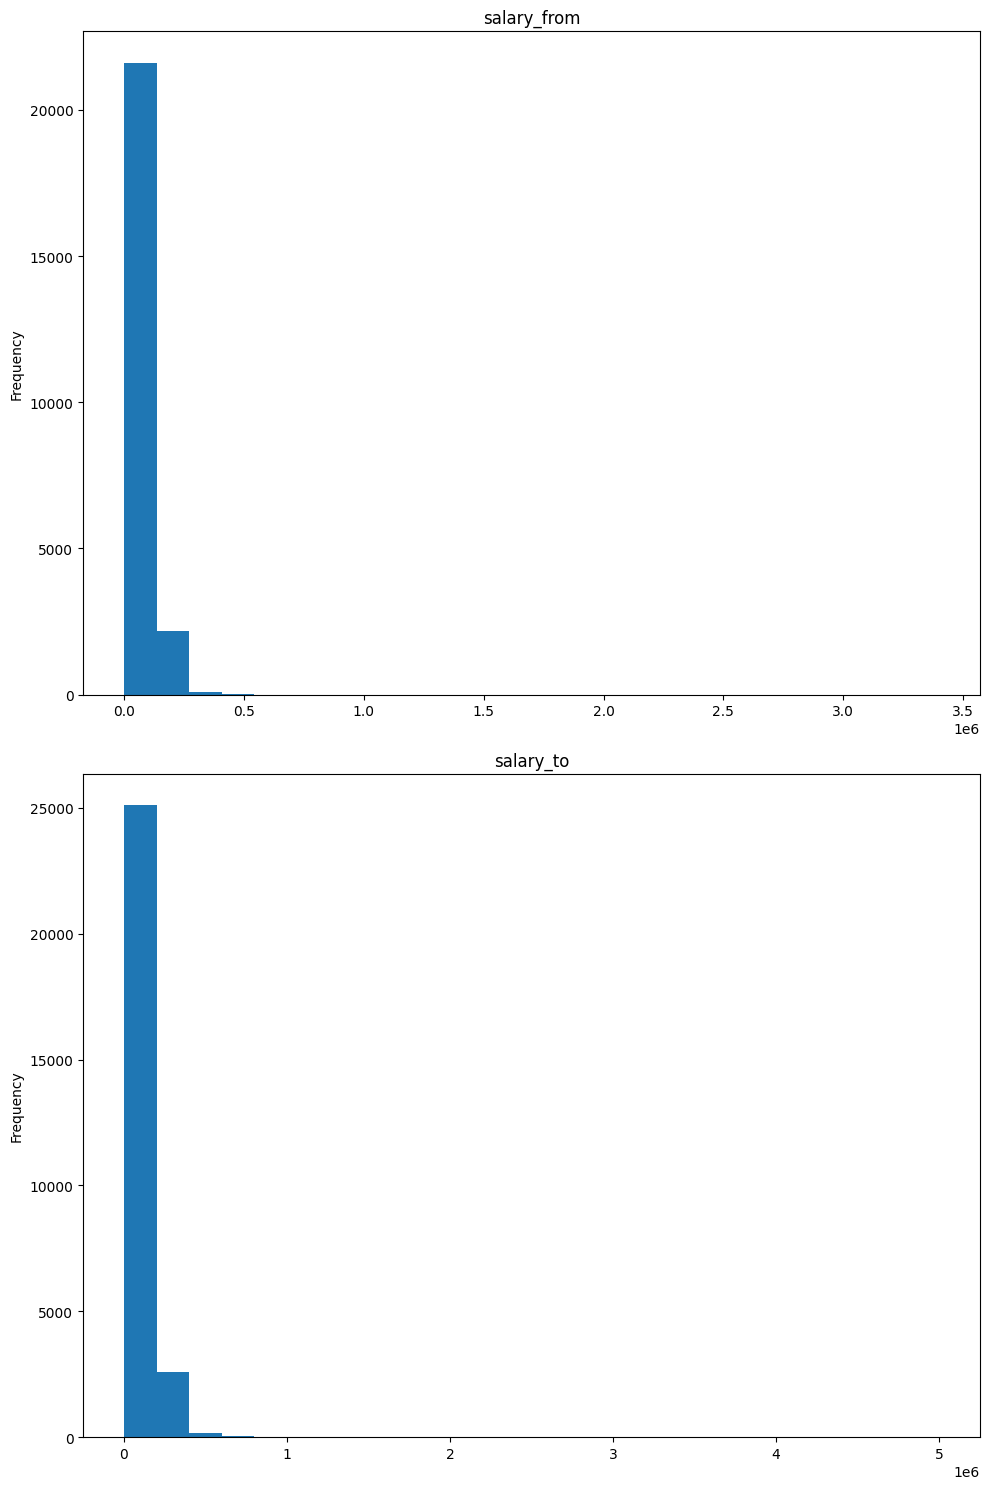

In [45]:
# Создаем гистограммы для всех столбцов
fig, axes = plt.subplots(nrows=len(df_numeric.columns), ncols=1, figsize=(10, 15))

# Проходимся по всем столбцам DataFrame и создаем гистограмму для каждого столбца
for i, column in enumerate(df_numeric.columns):
    df_numeric[column].plot(kind='hist', bins=25, ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

У нас в salary_from есть NaN значения.

In [46]:
df_nan = df[df['salary_from'].isna()]
df_nan

,area_name_Other,area_name_Москва,area_name_Санкт-Петербург,name_new1_Other,name_new1_Администратор,name_new1_Аналитик,name_new1_Бухгалтер,name_new1_Графический дизайнер,name_new1_Директор,name_new1_Инженер ПТО,...,employer_name_Other,employer_name_Билайн,employer_name_Перекресток,employer_name_Пятёрочка,has_test,response_letter_required,salary_from,salary_gross,published_at,salary_to
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-06-16 06:45:04+00:00,200000.0
24055,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-04-12 08:19:08+00:00,120000.0
20500,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-03-16 22:21:24+00:00,40000.0
22371,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-03-26 18:30:51+00:00,90000.0
14384,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2021-08-29 14:49:15+00:00,30000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6873,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2020-11-20 07:36:30+00:00,60000.0
17159,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,False,2021-08-16 07:39:39+00:00,100000.0
14502,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,NaN,True,2021-05-11 06:52:00+00:00,43000.0


Поместим среднее значение в эти строки:

In [47]:
df.salary_from.fillna(df.salary_from.min(), inplace = True) 
df

,area_name_Other,area_name_Москва,area_name_Санкт-Петербург,name_new1_Other,name_new1_Администратор,name_new1_Аналитик,name_new1_Бухгалтер,name_new1_Графический дизайнер,name_new1_Директор,name_new1_Инженер ПТО,...,employer_name_Other,employer_name_Билайн,employer_name_Перекресток,employer_name_Пятёрочка,has_test,response_letter_required,salary_from,salary_gross,published_at,salary_to
id,,,,,,,,,,,,,,,,,,,,,
29083,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,1.0,False,2020-06-16 06:45:04+00:00,200000.0
26052,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,120000.0,False,2020-07-22 10:24:15+00:00,170000.0
24055,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,1.0,False,2020-04-12 08:19:08+00:00,120000.0
4408,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,33500.0,True,2020-08-24 01:16:52+00:00,38000.0
16856,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,True,30000.0,True,2021-09-18 13:30:15+00:00,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,False,True,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,120000.0,False,2021-10-03 10:04:45+00:00,150000.0
6265,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,33500.0,True,2020-09-07 00:32:00+00:00,38000.0
11284,False,True,False,True,False,False,False,False,False,False,...,True,False,False,False,False,False,50000.0,False,2021-04-20 08:25:44+00:00,70000.0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   area_name_Other                 27934 non-null  bool               
 1   area_name_Москва                27934 non-null  bool               
 2   area_name_Санкт-Петербург       27934 non-null  bool               
 3   name_new1_Other                 27934 non-null  bool               
 4   name_new1_Администратор         27934 non-null  bool               
 5   name_new1_Аналитик              27934 non-null  bool               
 6   name_new1_Бухгалтер             27934 non-null  bool               
 7   name_new1_Графический дизайнер  27934 non-null  bool               
 8   name_new1_Директор              27934 non-null  bool               
 9   name_new1_Инженер ПТО           27934 non-null  bool               
 10  name_new1_К

Дропнем даты

In [49]:
df['published_at'] = df['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934 entries, 29083 to 15795
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   area_name_Other                 27934 non-null  bool   
 1   area_name_Москва                27934 non-null  bool   
 2   area_name_Санкт-Петербург       27934 non-null  bool   
 3   name_new1_Other                 27934 non-null  bool   
 4   name_new1_Администратор         27934 non-null  bool   
 5   name_new1_Аналитик              27934 non-null  bool   
 6   name_new1_Бухгалтер             27934 non-null  bool   
 7   name_new1_Графический дизайнер  27934 non-null  bool   
 8   name_new1_Директор              27934 non-null  bool   
 9   name_new1_Инженер ПТО           27934 non-null  bool   
 10  name_new1_Копирайтер            27934 non-null  bool   
 11  name_new1_Маркетолог            27934 non-null  bool   
 12  name_new1_Менеджер              2

<H1>Корреляция</H1>

In [51]:
df.corr().style.background_gradient(cmap='coolwarm')

,area_name_Other,area_name_Москва,area_name_Санкт-Петербург,name_new1_Other,name_new1_Администратор,name_new1_Аналитик,name_new1_Бухгалтер,name_new1_Графический дизайнер,name_new1_Директор,name_new1_Инженер ПТО,name_new1_Копирайтер,name_new1_Маркетолог,name_new1_Менеджер,name_new1_Оператор call-центра,name_new1_Охранник,name_new1_Продавец-кассир,name_new1_Продавец-консультант,name_new1_Разработчик,name_new1_Рекрутер,name_new1_Уборщица,name_new1_Юрист,employer_name_Other,employer_name_Билайн,employer_name_Перекресток,employer_name_Пятёрочка,has_test,response_letter_required,salary_from,salary_gross,published_at,salary_to
area_name_Other,1.000000,-0.465257,-0.136892,-0.044200,0.012015,0.006058,0.021389,0.079775,-0.026141,-0.018536,-0.017664,-0.014239,-0.055973,-0.010663,-0.017915,-0.062969,-0.027337,0.205172,0.031915,-0.031933,-0.041367,0.079902,-0.022878,-0.030317,-0.068893,0.031305,0.007878,0.022669,-0.041909,-0.292569,0.033881
area_name_Москва,-0.465257,1.000000,-0.813153,-0.020488,-0.010711,0.024135,-0.016508,-0.033903,0.051493,0.030008,0.037234,0.031892,0.045896,0.012448,-0.089892,0.000238,-0.032548,-0.073647,-0.019548,0.045609,0.075642,0.000759,-0.029192,-0.030213,0.025160,-0.001626,0.006627,0.052836,0.004232,0.046759,0.043771
area_name_Санкт-Петербург,-0.136892,-0.813153,1.000000,0.051992,0.004086,-0.030993,0.004410,-0.014516,-0.040436,-0.021393,-0.030053,-0.026327,-0.014557,-0.006919,0.112377,0.041139,0.054399,-0.052495,0.000889,-0.030043,-0.057449,-0.053390,0.047712,0.053746,0.017144,-0.018765,-0.012597,-0.074034,0.022822,0.140052,-0.071262
name_new1_Other,-0.044200,-0.020488,0.051992,1.000000,-0.191918,-0.087609,-0.128502,-0.071064,-0.119456,-0.071064,-0.081693,-0.107771,-0.459930,-0.086891,-0.068685,-0.241415,-0.104805,-0.375919,-0.092934,-0.122426,-0.165610,0.180893,0.018893,0.025882,-0.228872,-0.003361,0.009385,-0.005297,-0.036446,0.030142,-0.007355
name_new1_Администратор,0.012015,-0.010711,0.004086,-0.191918,1.000000,-0.014605,-0.021422,-0.011847,-0.019914,-0.011847,-0.013619,-0.017966,-0.076672,-0.014485,-0.011450,-0.040245,-0.017471,-0.062667,-0.015492,-0.020409,-0.027608,-0.155036,-0.017371,-0.013589,0.192681,-0.003837,-0.015699,-0.057181,0.053401,0.047094,-0.079846
name_new1_Аналитик,0.006058,0.024135,-0.030993,-0.087609,-0.014605,1.000000,-0.009779,-0.005408,-0.009090,-0.005408,-0.006217,-0.008201,-0.035000,-0.006612,-0.005227,-0.018371,-0.007976,-0.028607,-0.007072,-0.009316,-0.012603,0.023762,-0.007930,-0.008845,-0.020100,-0.001917,-0.002736,0.010685,0.012222,-0.057595,0.002999
name_new1_Бухгалтер,0.021389,-0.016508,0.004410,-0.128502,-0.021422,-0.009779,1.000000,-0.007932,-0.013334,-0.007932,-0.009119,-0.012029,-0.051337,-0.009699,-0.007667,-0.026947,-0.011698,-0.041960,-0.010373,-0.013665,-0.018485,0.034853,-0.011631,-0.012974,-0.029481,0.009657,-0.006852,-0.027998,-0.014322,0.026383,-0.053315
name_new1_Графический дизайнер,0.079775,-0.033903,-0.014516,-0.071064,-0.011847,-0.005408,-0.007932,1.000000,-0.007374,-0.004387,-0.005043,-0.006652,-0.028390,-0.005364,-0.004240,-0.014902,-0.006469,-0.023205,-0.005737,-0.007557,-0.010223,0.019274,-0.006432,-0.007175,-0.016304,0.003153,0.020360,-0.022515,-0.004868,-0.076317,-0.022326
name_new1_Директор,-0.026141,0.051493,-0.040436,-0.119456,-0.019914,-0.009090,-0.013334,-0.007374,1.000000,-0.007374,-0.008477,-0.011182,-0.047723,-0.009016,-0.007127,-0.025050,-0.010875,-0.039006,-0.009643,-0.012703,-0.017184,-0.005215,-0.010812,-0.005980,0.013268,0.002786,0.012948,0.103349,0.013341,-0.031920,0.125689
name_new1_Инженер ПТО,-0.018536,0.030008,-0.021393,-0.071064,-0.011847,-0.005408,-0.007932,-0.004387,-0.007374,1.000000,-0.005043,-0.006652,-0.028390,-0.005364,-0.004240,-0.014902,-0.006469,-0.023205,-0.005737,-0.007557,-0.010223,0.019274,-0.006432,-0.007175,-0.016304,-0.000303,-0.013327,0.006252,-0.017572,0.015441,-0.014053


<H1>Создание модели</H1>

In [82]:
from sklearn.model_selection import train_test_split


df_sampled = df.sample(25_000)

X_train, X_test, y_train, y_test = train_test_split(df_sampled.drop(columns='salary_to'), df_sampled.salary_to, random_state=1234)

In [83]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 33315 to 31454
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   area_name_Other                 25000 non-null  bool   
 1   area_name_Москва                25000 non-null  bool   
 2   area_name_Санкт-Петербург       25000 non-null  bool   
 3   name_new1_Other                 25000 non-null  bool   
 4   name_new1_Администратор         25000 non-null  bool   
 5   name_new1_Аналитик              25000 non-null  bool   
 6   name_new1_Бухгалтер             25000 non-null  bool   
 7   name_new1_Графический дизайнер  25000 non-null  bool   
 8   name_new1_Директор              25000 non-null  bool   
 9   name_new1_Инженер ПТО           25000 non-null  bool   
 10  name_new1_Копирайтер            25000 non-null  bool   
 11  name_new1_Маркетолог            25000 non-null  bool   
 12  name_new1_Менеджер              2

In [84]:
df.salary_to.describe()

count    2.793400e+04
mean     1.044182e+05
std      1.052993e+05
min      1.000000e+01
25%      4.500000e+04
50%      7.000000e+04
75%      1.400000e+05
max      5.000000e+06
Name: salary_to, dtype: float64

In [85]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [86]:
%%time
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)

y_pred_train = model_LR.predict(X_train)
y_pred_test = model_LR.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 39829.73766675492, MAE test: 37488.280706667974
MSE train: 7745718503.8435335, MSE test: 3586459895.2435327
MAPE train: 1.346904568608907, MAPE test: 1.7670703436316229
SMAPE train: 40.235300101501146, SMAPE test: 39.25087547241666
CPU times: user 104 ms, sys: 594 ms, total: 698 ms
Wall time: 108 ms


In [87]:
model_SGR = SGDRegressor() # epsilon_insensitive, huber, squared_loss
model_SGR.fit(X_train, y_train)

y_pred_train = model_SGR.predict(X_train)
y_pred_test = model_SGR.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 5.9376625667981775e+23, MAE test: 5.926198681864053e+23
MSE train: 3.6165191835753994e+47, MSE test: 3.6031555855841822e+47
MAPE train: 2.2548248946242482e+19, MAPE test: 3.0096080864061043e+19
SMAPE train: 200.0, SMAPE test: 200.0


In [88]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


model = RandomForestRegressor(n_estimators=200, max_depth=2000)#, criterion='friedman_mse')
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f'MAE train: {mean_absolute_error(y_train, y_pred_train)}, MAE test: {mean_absolute_error(y_test, y_pred_test)}')
print(f'MSE train: {mean_squared_error(y_train, y_pred_train)}, MSE test: {mean_squared_error(y_test, y_pred_test)}')
print(f'MAPE train: {mean_absolute_percentage_error(y_train, y_pred_train)}, MAPE test: {mean_absolute_percentage_error(y_test, y_pred_test)}')
print(f'SMAPE train: {smape(y_train, y_pred_train)}, SMAPE test: {smape(y_test, y_pred_test)}')

MAE train: 12897.087681093122, MAE test: 32267.935232236196
MSE train: 1111528309.0252135, MSE test: 3471118960.22008
MAPE train: 0.6265218259571909, MAPE test: 2.0858912060493204
SMAPE train: 12.403433760535242, SMAPE test: 29.626700229547794
CPU times: user 17.1 s, sys: 0 ns, total: 17.1 s
Wall time: 17.6 s


<H1>Тестовая дата</H1>

In [89]:
df_test = pd.read_csv('X_test.csv', parse_dates=['published_at', 'created_at'])

In [90]:
df_test = df_test.drop(columns=['description', 'salary_currency', 'created_at', 'area_id'])

In [91]:
df_test = df_test.set_index('id')

In [92]:
df_test.loc[df_test["area_name"].value_counts()[df_test["area_name"]].values < 1000, "area_name"] = "Other"

In [93]:
df_test = df_test.replace(to_replace ="Пятерочка", value ="Пятёрочка") 

In [94]:
df_test.loc[df_test["employer_name"].value_counts()[df_test["employer_name"]].values < 100, "employer_name"] = "Other"

In [95]:
df_test = pd.concat([df_test, df_test.name.str.split('(', expand=True)[0]\
                .rename('name_new')], axis=1)
df_test = pd.concat([df_test, df_test.name_new.str.split('/', expand=True)[0]\
                .rename('name_new1')], axis=1)

In [96]:
df_test['name_new1'] = df_test['name_new1'].str.strip()

In [97]:
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Менеджер по продажам' if (('менеджер' in x or 'Менеджер' in x) and ('продаж' in x or 'Продаж' in x)) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Маркетолог' if ('маркетолог' in x or 'Маркетолог' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Менеджер' if ('менеджер' in x or 'Менеджер' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Бухгалтер' if ('бухгалтер' in x or 'Бухгалтер' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Юрист' if ('юрист' in x or 'Юрист' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Директор' if ('директор' in x or 'Директор' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Разработчик' if ('Разработчик' in x or 'разработчик' in x or 'Программист' in x or 'программист' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Продавец-кассир' if ('Продавец-кассир' in x or 'продавец-кассир' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Администратор' if ('Администратор' in x or 'администратор' in x) else x)
df_test.name_new1 = df_test.name_new1.apply(lambda x: 'Other' if (not ('Менеджер по продажам' in x or 'Маркетолог' in x or 'Менеджер' in x or 'Бухгалтер' in x or 'Юрист' in x or 'Директор' in x or 'Разработчик' in x or 'Продавец-кассир' in x or 'Администратор' in x)) else x)
#df_test.loc[df_test["name_new1"].value_counts()[df_test["name_new1"]].values < 110, "name_new1"] = "Other"

In [98]:
df_test = df_test.drop(columns=['name', 'name_new'])

In [99]:
df_test['salary_gross'] = df_test['salary_gross'].astype(bool)

In [100]:
df_one_hoted_test = df_test.copy()

ONE_HOT_COL_TEST = ['area_name', 'name_new1', 'employer_name']

temp_test = pd.get_dummies(df_one_hoted_test[ONE_HOT_COL_TEST], prefix=ONE_HOT_COL_TEST, dtype=bool)

df_one_hoted_test = pd.concat([temp_test, df_test], axis=1)

In [101]:
df_one_hoted_test = df_one_hoted_test.drop(columns=['employer_name', 'area_name', 'name_new1'])

In [102]:
df_test = df_one_hoted_test

In [103]:
df_test['published_at'] = df_test['published_at'].map(lambda x: datetime.now().timestamp() - x.timestamp())

In [104]:
for columnName in df_test.columns:
    print(columnName)

area_name_Other
area_name_Москва
area_name_Санкт-Петербург
name_new1_Other
name_new1_Администратор
name_new1_Бухгалтер
name_new1_Директор
name_new1_Маркетолог
name_new1_Менеджер
name_new1_Продавец-кассир
name_new1_Разработчик
name_new1_Юрист
employer_name_Other
employer_name_Перекресток
employer_name_Пятёрочка
has_test
response_letter_required
salary_from
salary_gross
published_at


In [105]:
for columnName in df.columns:
    print(columnName)
    if not (columnName in df_test.columns) and (columnName != 'salary_to'):
        df_test[columnName] = [False] * df_test.shape[0]

area_name_Other
area_name_Москва
area_name_Санкт-Петербург
name_new1_Other
name_new1_Администратор
name_new1_Аналитик
name_new1_Бухгалтер
name_new1_Графический дизайнер
name_new1_Директор
name_new1_Инженер ПТО
name_new1_Копирайтер
name_new1_Маркетолог
name_new1_Менеджер
name_new1_Оператор call-центра
name_new1_Охранник
name_new1_Продавец-кассир
name_new1_Продавец-консультант
name_new1_Разработчик
name_new1_Рекрутер
name_new1_Уборщица
name_new1_Юрист
employer_name_Other
employer_name_Билайн
employer_name_Перекресток
employer_name_Пятёрочка
has_test
response_letter_required
salary_from
salary_gross
published_at
salary_to


In [106]:
df_test.salary_from.fillna(df_test.salary_from.mean(), inplace = True) 

In [107]:
df_test.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Санкт-Петербург',
       'name_new1_Other', 'name_new1_Администратор', 'name_new1_Бухгалтер',
       'name_new1_Директор', 'name_new1_Маркетолог', 'name_new1_Менеджер',
       'name_new1_Продавец-кассир', 'name_new1_Разработчик', 'name_new1_Юрист',
       'employer_name_Other', 'employer_name_Перекресток',
       'employer_name_Пятёрочка', 'has_test', 'response_letter_required',
       'salary_from', 'salary_gross', 'published_at', 'name_new1_Аналитик',
       'name_new1_Графический дизайнер', 'name_new1_Инженер ПТО',
       'name_new1_Копирайтер', 'name_new1_Оператор call-центра',
       'name_new1_Охранник', 'name_new1_Продавец-консультант',
       'name_new1_Рекрутер', 'name_new1_Уборщица', 'employer_name_Билайн'],
      dtype='object')

In [108]:
df.columns

Index(['area_name_Other', 'area_name_Москва', 'area_name_Санкт-Петербург',
       'name_new1_Other', 'name_new1_Администратор', 'name_new1_Аналитик',
       'name_new1_Бухгалтер', 'name_new1_Графический дизайнер',
       'name_new1_Директор', 'name_new1_Инженер ПТО', 'name_new1_Копирайтер',
       'name_new1_Маркетолог', 'name_new1_Менеджер',
       'name_new1_Оператор call-центра', 'name_new1_Охранник',
       'name_new1_Продавец-кассир', 'name_new1_Продавец-консультант',
       'name_new1_Разработчик', 'name_new1_Рекрутер', 'name_new1_Уборщица',
       'name_new1_Юрист', 'employer_name_Other', 'employer_name_Билайн',
       'employer_name_Перекресток', 'employer_name_Пятёрочка', 'has_test',
       'response_letter_required', 'salary_from', 'salary_gross',
       'published_at', 'salary_to'],
      dtype='object')

In [109]:
columns = df.columns.tolist();
columns.remove('salary_to');
df_test = df_test[columns]

In [110]:
y_pred_test1 = model.predict(df_test)

In [111]:
df_test_full = df_test.assign(salary_to = y_pred_test1)

In [112]:
df_output = pd.concat([df_test_full['salary_to']])
df_output

id
20978     41600.0
3102      37435.0
14731    300350.0
16113    339400.0
8410     145487.5
           ...   
29490     61905.0
34298     50810.0
33921     39015.0
8886      76277.5
23978     50252.5
Name: salary_to, Length: 9312, dtype: float64

In [113]:
from pathlib import Path  
filepath = Path('y_test.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_output.to_csv(filepath)  